In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if "AnalyzedData" in parts:
            idx = parts.index("AnalyzedData")
            
            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "ChipID", "RunID", "WellID"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
print(df.head())

# 5. SAVE
df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index.csv", index=False)

 dissecting path names...
Successfully dissected 366 paths.

Snapshot of extracted metadata:
    Project    Date  ChipID   RunID   WellID  \
0  CDKL5_T1  240607  M08018  000095  well000   
1  CDKL5_T1  240607  M08018  000095  well003   
2  CDKL5_T1  240607  M08018  000095  well004   
3  CDKL5_T1  240607  M08018  000095  well001   
4  CDKL5_T1  240607  M08018  000095  well002   

                                           full_path  
0  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
1  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
2  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
3  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  
4  /pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...  


In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['mean_firing_rate', 'mean_burst_rate', 'network_burst_frequency', 'burst_duration_mean']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- unit_bursts: (Nested Dictionary)
  - 5: (Nested Dictionary)
    - bursts: List [148 items]
    - isis_all: List [925 items]
  - 6: (Nested Dictionary)
    - bursts: List [263 items]
    - isis_all: List [1669 items]
  - 18: (Nested Dictionary)
    - bursts: List [72 items]
    - isis_all: List [451 items]
  - 22: (Nested Dictionary)
    - bursts: List [79 items]
    - isis_all: List [464 items]
  - 23: (Nested Dictionary)
    - bursts: List [35 items]
    - isis_all: List [200 items]
  - 25: (Nested Dictionary)
    - bursts: List [39 items]
    - isis_all: List [272 items]
  - 27: (Nested Dictionary)
    - bursts: List [85 items]
    - isis_all: List [537 items]
  - 31: (Nested Dictionary)
    - bursts: List [17 items]
    - isis_all: List [172 items]
  - 32: (Nested Dictionary)
    - bursts: List [15 items]
    - isis_all: List [97 items]
  - 33: (Nested Dictionary)
    - bursts: List [30 items]
    - isis_all: List [235 items]
  - 34: (Nested Dictionary)

In [3]:
import json
import pandas as pd
import numpy as np
# Optional: Use tqdm for a progress bar if installed, otherwise regular loop
try:
    from tqdm import tqdm
    tqdm.pandas()
    iterable = tqdm(df.iterrows(), total=len(df), desc="Extracting Metrics")
except ImportError:
    iterable = df.iterrows()
    print("Extracting metrics (install 'tqdm' for a progress bar)...")

# --- 1. DEFINE EXTRACTION LOGIC ---
def extract_metrics(row):
    path = row['full_path']
    
    # Initialize default values (NaN) in case file is empty/corrupt
    metrics = {
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,        # Duration is usually in seconds
        "nb_ibi_mean_s": np.nan,             # Inter-Burst Interval
        "nb_spikes_per_burst_mean": np.nan,
        "nb_energy_mean": np.nan,            # Often informative for connectivity
        "psib": np.nan                       # Percentage of Spikes in Bursts
    }

    try:
        with open(path, 'r') as f:
            data = json.load(f)
        
        # Access the specific nested keys you identified
        # We use .get() to avoid crashing if a specific key is missing
        if 'network_stats' in data:
            ns = data['network_stats']
            
            metrics["nb_count"] = ns.get('count')
            metrics["nb_rate_hz"] = ns.get('rate_hz')
            
            # Nested: Duration
            if 'duration' in ns:
                metrics["nb_duration_mean_s"] = ns['duration'].get('mean')
            
            # Nested: IBI
            if 'inter_burst_interval' in ns:
                metrics["nb_ibi_mean_s"] = ns['inter_burst_interval'].get('mean')
                
            # Nested: Intensity (Energy, Spikes, PSIB)
            if 'intensity' in ns:
                inte = ns['intensity']
                metrics["psib"] = inte.get('psib')
                
                if 'spikes' in inte:
                    metrics["nb_spikes_per_burst_mean"] = inte['spikes'].get('mean')
                if 'energy' in inte:
                    metrics["nb_energy_mean"] = inte['energy'].get('mean')

    except Exception as e:
        print(f"Error reading {path}: {e}")
        
    return pd.Series(metrics)

# --- 2. RUN EXTRACTION ---
# We apply the function to every row in your existing DataFrame
# and join the new columns to the right side of the metadata
print("Starting extraction...")
df_metrics = df.apply(extract_metrics, axis=1)
final_df = pd.concat([df, df_metrics], axis=1)

# --- 3. CLEAN UP & SAVE ---
# Convert DIV to numeric if it exists, drop rows where extraction failed completely (optional)
# final_df.dropna(subset=['nb_rate_hz'], inplace=True) 

print(f"\nExtraction complete. Dataframe shape: {final_df.shape}")
print(final_df[['Project', 'ChipID', 'nb_rate_hz', 'nb_duration_mean_s', 'psib']].head())

# Save the Master Table
output_csv = "/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/Network_Analysis_Master.csv"
final_df.to_csv(output_csv, index=False)
print(f"Master table saved to: {output_csv}")

Extracting Metrics:   0%|                                                                                                                                                                                                                                                  | 0/366 [00:00<?, ?it/s]

Starting extraction...

Extraction complete. Dataframe shape: (366, 13)
    Project  ChipID  nb_rate_hz  nb_duration_mean_s       psib
0  CDKL5_T1  M08018    0.303255            0.902527  49.580040
1  CDKL5_T1  M08018    0.396565            0.935714  60.559541
2  CDKL5_T1  M08018    0.423230            0.586378  42.053543
3  CDKL5_T1  M08018    0.153315            0.419565   7.876058
4  CDKL5_T1  M08018    0.289930            0.731724  47.981669
Master table saved to: /pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/Network_Analysis_Master.csv


In [4]:
ref_df = pd.read_excel("/pscratch/sd/m/mpatil1/Data/CDKL5_T1/CDKL5_T1_C1_reff.xlsx")
print(ref_df.columns)




# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
# We split by comma and implicitly handle the 1:1 mapping
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')

# Step B: Explode the lists into rows
# Pandas >= 1.3.0 allows exploding multiple columns simultaneously to keep them aligned
# This is crucial so Index 0 of Wells stays with Index 0 of Source
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])

# Step C: Cleanup
# Remove whitespace that might exist in the strings (e.g., " MxWT" -> "MxWT")
exploded_df['Well_Num'] = exploded_df['Wells_List'].str.strip()
exploded_df['Neuron Source'] = exploded_df['Source_List'].str.strip()

# Step D: Create a "Match Key" for merging with your JSON results
# Your files are named like 'well005', so we format the number '5' -> 'well005'
exploded_df['WellID'] = 'well' + exploded_df['Well_Num'].str.zfill(3)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #','WellID', 'Neuron Source', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print(f"Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save this for the next step
#clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source'],
      dtype='object')
Transformation complete.
Original rows: 109
Exploded rows: 654

First 10 rows of clean metadata:
        Date      ID  Run #   WellID Neuron Source          Assay  DIV
0 2024-05-20  M07420      1  well001          MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well002          MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well003          MxWT       Sparse7x    5
0 2024-05-20  M07420      1  well004         FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well005         FxHET       Sparse7x    5
0 2024-05-20  M07420      1  well006         FxHET       Sparse7x    5
1 2024-05-20  M07420      2  well001          MxWT  Network Today    5
1 2024-05-20  M07420      2  well002          MxWT  Network Today    5
1 2024-05-20  M07420      2  well003          MxWT  Network Today    5
1 2024-05-20  M07420      2  well004         FxHET  Network Today    5


In [5]:

final_df.rename(columns={"ChipID": "ID"}, inplace=True)
final_df.rename(columns={"RunID": "Run #"}, inplace=True)

In [8]:
final_df.head()

,Project,Date,ID,Run #,WellID,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,nb_spikes_per_burst_mean,nb_energy_mean,psib
0,CDKL5_T1,240607,M08018,000095,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,91.0,0.303255,0.902527,2.378222,1056.043956,137.259145,49.580040
1,CDKL5_T1,240607,M08018,000095,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,119.0,0.396565,0.935714,1.574915,771.075630,82.384318,60.559541
2,CDKL5_T1,240607,M08018,000095,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,127.0,0.423230,0.586378,1.769603,226.102362,14.060290,42.053543
3,CDKL5_T1,240607,M08018,000095,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,46.0,0.153315,0.419565,5.928222,308.282609,23.196293,7.876058
4,CDKL5_T1,240607,M08018,000095,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,87.0,0.289930,0.731724,2.688256,577.655172,67.205943,47.981669


In [9]:
#make Run # elemets to int
final_df['Run #'] = final_df['Run #'].astype(int)

In [10]:
#merge on ID and WellID and Run #
merged_df = pd.merge(final_df, clean_ref_df, how='left', left_on=['ID', 'WellID', 'Run #'], right_on=['ID', 'WellID', 'Run #'])


In [11]:
merged_df.head()

,Project,Date_x,ID,Run #,WellID,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,nb_spikes_per_burst_mean,nb_energy_mean,psib,Date_y,Neuron Source,Assay,DIV
0,CDKL5_T1,240607,M08018,95,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,91.0,0.303255,0.902527,2.378222,1056.043956,137.259145,49.580040,NaT,NaN,NaN,NaN
1,CDKL5_T1,240607,M08018,95,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,119.0,0.396565,0.935714,1.574915,771.075630,82.384318,60.559541,2024-06-07,FxHET,Neuronal Units 9,23.0
2,CDKL5_T1,240607,M08018,95,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,127.0,0.423230,0.586378,1.769603,226.102362,14.060290,42.053543,2024-06-07,MxHEMI,Neuronal Units 9,23.0
3,CDKL5_T1,240607,M08018,95,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,46.0,0.153315,0.419565,5.928222,308.282609,23.196293,7.876058,2024-06-07,MxHEMI,Neuronal Units 9,23.0
4,CDKL5_T1,240607,M08018,95,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,87.0,0.289930,0.731724,2.688256,577.655172,67.205943,47.981669,2024-06-07,MxWT,Neuronal Units 9,23.0


In [12]:
#keep only DateX and delete Date_y
merged_df.drop(columns=['Date_y'], inplace=True)
merged_df.rename(columns={"Date_x": "Date"}, inplace=True)

In [13]:
#order by run #
merged_df.sort_values(by=['ID', 'Run #', 'WellID'], inplace=True)

In [14]:
merged_df.head()

,Project,Date,ID,Run #,WellID,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,nb_spikes_per_burst_mean,nb_energy_mean,psib,Neuron Source,Assay,DIV
232,CDKL5_T1,240520,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,26.0,0.086663,0.876538,10.871200,862.730769,48.301495,20.023745,NaN,NaN,NaN
235,CDKL5_T1,240520,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1.0,0.003333,0.940000,0.000000,2005.000000,157.940854,1.066671,MxHEMI,Network Today,5.0
236,CDKL5_T1,240520,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,12.0,0.040000,0.860833,22.447273,755.916667,35.732843,8.406702,MxWT,Network Today,5.0
233,CDKL5_T1,240520,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,19.0,0.063335,0.934211,15.409444,850.894737,40.339697,23.580805,FxHET,Network Today,5.0
234,CDKL5_T1,240520,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1.0,0.003333,0.950000,0.000000,2435.000000,216.419497,1.535154,MxHEMI,Network Today,5.0


In [15]:
#Calcuate DIV based on Date and Date of plating
plating_date = '240515'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days
merged_df.head()

,Project,Date,ID,Run #,WellID,full_path,nb_count,nb_rate_hz,nb_duration_mean_s,nb_ibi_mean_s,nb_spikes_per_burst_mean,nb_energy_mean,psib,Neuron Source,Assay,DIV
232,CDKL5_T1,2024-05-20,M07039,6,well000,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,26.0,0.086663,0.876538,10.871200,862.730769,48.301495,20.023745,NaN,NaN,5
235,CDKL5_T1,2024-05-20,M07039,6,well001,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1.0,0.003333,0.940000,0.000000,2005.000000,157.940854,1.066671,MxHEMI,Network Today,5
236,CDKL5_T1,2024-05-20,M07039,6,well002,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,12.0,0.040000,0.860833,22.447273,755.916667,35.732843,8.406702,MxWT,Network Today,5
233,CDKL5_T1,2024-05-20,M07039,6,well003,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,19.0,0.063335,0.934211,15.409444,850.894737,40.339697,23.580805,FxHET,Network Today,5
234,CDKL5_T1,2024-05-20,M07039,6,well004,/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedDa...,1.0,0.003333,0.950000,0.000000,2435.000000,216.419497,1.535154,MxHEMI,Network Today,5


In [16]:
merged_df.columns

Index(['Project', 'Date', 'ID', 'Run #', 'WellID', 'full_path', 'nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib', 'Neuron Source',
       'Assay', 'DIV'],
      dtype='object')

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


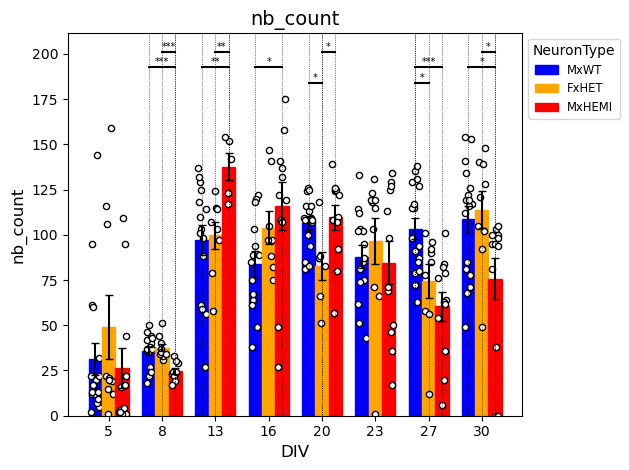

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


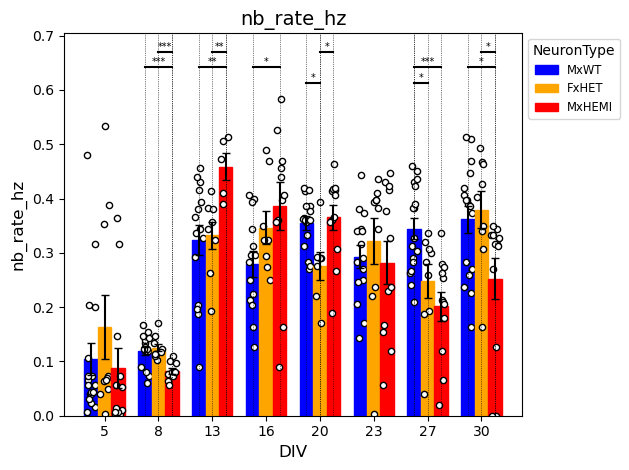

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


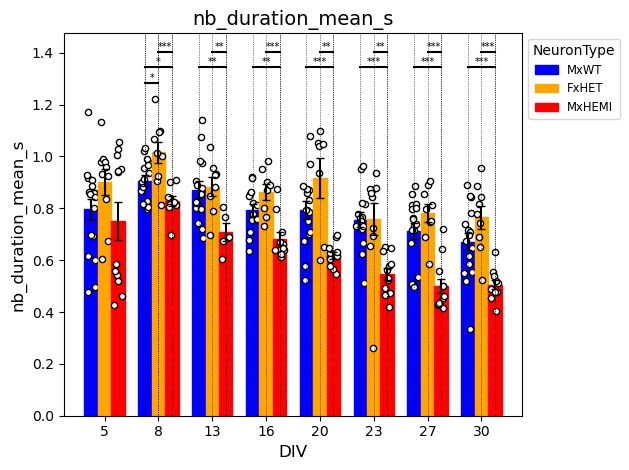

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


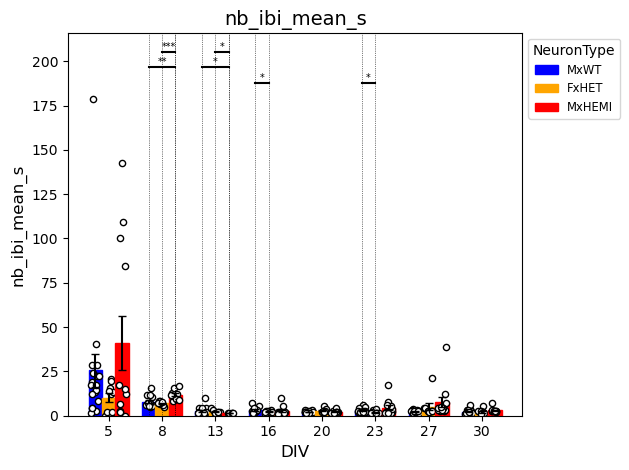

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


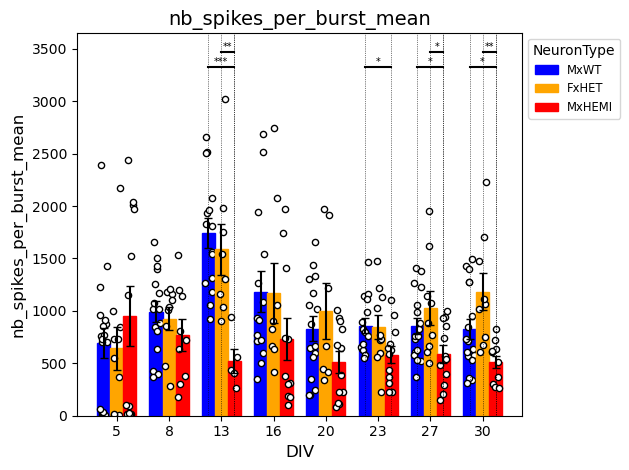

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


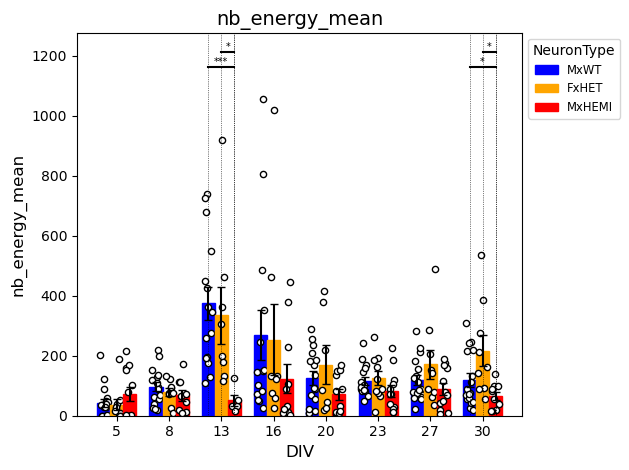

Number of unique Genotypes: 3
['MxWT', 'FxHET', 'MxHEMI']


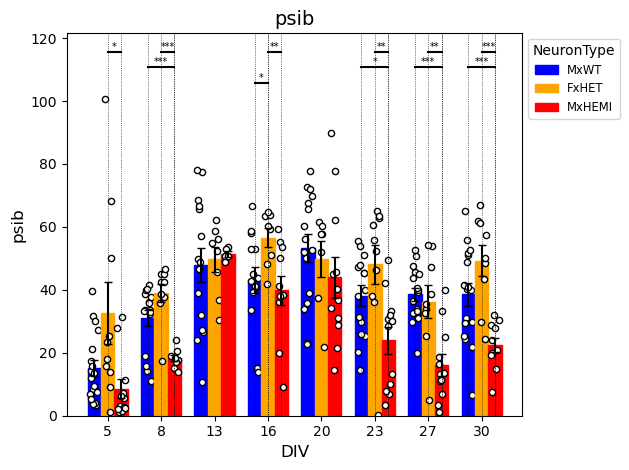

In [18]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
df = merged_df.copy()
output_types = ['nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib']

div = sorted(df['DIV'].unique())

unique_genotypes = [ 'MxWT', 'FxHET' ,'MxHEMI']

colors = ['blue','orange','red']
markers = ['o','o','d','*','^']

#dirpath = '/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_E6T1_Apr29/plots/'
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['Neuron Source'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['ID']))
            well_arrays[genotype].append(np.array(temp_df['WellID']))
    #print(df)
    # Adjust bar width and gap between them
    bar_width = 0.25  # Adjust as necessary for your specific plot
    gap_between_bars = 0  # Adjust the gap between bars within a group

    # Calculate the total width for all bars in a group
    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars

    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))  # Base x-coordinates for each group
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)



    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=colors[i], edgecolor=colors[i], ecolor='black', label=genotype,alpha=1.0)

        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.08
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=20,
                    color='white',
                    marker='o',
                    edgecolors='black'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(base_x_coordinate)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    


   # Adjustments for plot aesthetics
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)

    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout() 
    plt.show() # Adjust layout to prevent clipping of ylabel
    #plt.legend(title='NeuronType',loc='upper right', fontsize='x-small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
   # import os 
    
    #if not os.path.exists(dirpath):
    #        os.makedirs(dirpath)
    #plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')